# WIN-TAC-TOE ALPHA DRAFT

### Import section

In [6]:
import numpy as np
import gym

import sys
sys.path.append('/home/jan/WinTacToe/src/extensions/games/tic_tac_toe')
from tic_tac_toe_logic import *
from tic_tac_toe import *

import random
from graphviz import Graph, Digraph
import matplotlib.pyplot as plt
import uuid

### Basic RL Agent building blocks

In [7]:
class State:
    def __init__(self, array):
        self.array = np.array(array)
    
    def __hash__(self):
        return hash(self.array.tostring())
    
    def __eq__(self, other):
        if not isinstance(other, State):
            return NotImplemented
        return hash(self) == hash(other)
    
    def __str__(self):
#         return str(self.array)
        representation = ''
        height, width = self.array.shape
        
        for h in range(height):
            for w in range(width):
                if self.array[h,w] == -1:
                    representation += '#'
                elif self.array[h,w] == 0:
                    representation += 'O'
                elif self.array[h,w] == 1:
                    representation += 'X'
                else:
                    print("Invalid mark code")
                    raise
            if h < height-1:
                representation += '\n'
        return representation
        
    
    def __repr__(self):
        return self.__str__()

In [8]:
class Action:
    def __init__(self, array):
        self.array = np.array(array)
    
    def __hash__(self):
        return hash(self.array.tostring())
    
    def __eq__(self, other):
        if not isinstance(other, Action):
            return NotImplemented
        return hash(self) == hash(other)
    
    def __str__(self):
        return str(self.array)
    
    def __repr__(self):
        return self.__str__()

In [9]:
class Policy:
    def __init__(self, env):
        self.policy_dict = {}
    
    # Lazy initialization
    def __getitem__(self, state):
        if self.policy_dict.get(state) is None:
            if env.possible_actions:
                self.policy_dict[state] = Action(random.choice(env.possible_actions))
            else:
                self.policy_dict[state] = Action([])
        return self.policy_dict[state]
    
    def __setitem__(self, state, action):
        self.policy_dict[state] = action
    
    def __str__(self):
        representation = ''
        for key, value in self.policy_dict.items():
            representation += str(key)
            representation += "\n"
            representation += str(value)
            representation += "\n\n"
        return representation
    def __repr__(self):
        return self.__str__()
    
    def _repr_svg_(self):
        graph = Digraph()
        for state, action in self.policy_dict.items():
            graph.attr('node', shape='doublecircle')
            state_hash = str(hash(state))
            graph.node(state_hash, str(state))
            graph.attr('node', shape='circle')
            action_hash = str(hash(action))
            graph.node(action_hash, str(action))
            graph.edge(state_hash, action_hash)
                    
        return graph._repr_svg_()

In [155]:
players = [Player('A', 0), Player('B', 1)]
size = 3
marks_required = 3
env = gym.make('tic_tac_toe:tictactoe-v0')

p = Policy(env)

s1 = State([[-1,1],[-1,0]])
a1 = Action([1,0])
p[s1] = a1

s2 = State([[-1,0],[1,0]])
a2 = Action([0,0])
p[s2] = a2

s3 = State([[0,1],[1,-1]])
a3 = Action([1,1])
p[s3] = a3

p[s3]

[1 1]

In [11]:
class ActionValue:
    def __init__(self):
        self.action_value_dict = {}
            
    # Lazy initialization
    def __getitem__(self, key):
        if type(key) == tuple and len(key) == 2:
            state, action = key
            if self.action_value_dict.get(state) is None:
                self.action_value_dict[state] = {action : 0} # Arbitrarily initialization
            elif self.action_value_dict[state].get(action) is None:
                self.action_value_dict[state][action] = 0 # Arbitrarily initialization
                
            return self.action_value_dict[state][action]
        
        elif type(key) == State:
            return self.action_value_dict[key]
    
    def get_state_actions(self, state):
        return self.action_value_dict.get(state)
    
    def __setitem__(self, key, value):
        state, action = key
        if self.action_value_dict.get(state) is None:
            self.action_value_dict[state] = {}
        self.action_value_dict[state][action] = value
        
    # Argmax over action as argument, state is constant
    # Settle draw randomly with uniform distribution
    def argmax_a(self, state):
        max_value = float('-inf')
        max_value_actions = []
        for action, value in self.action_value_dict[state].items():
            if value > max_value:
                max_value = value
                max_value_actions = [action]
            elif value == max_value:
                max_value_actions.append(action)
        return random.choice(max_value_actions)
    
    def __str__(self):
        return str(self.action_value_dict)
    
    def __repr__(self):
        return self.__str__()
    
    def _repr_svg_(self):
        graph = Digraph()
        for state, actions in self.action_value_dict.items():
            graph.node(str(hash(state)), str(state))
            for action, value in actions.items():
                graph.node(str(hash(action)), str(action))
                graph.edge(str(hash(state)), str(hash(action)), label=str(value))
        return graph._repr_svg_()       

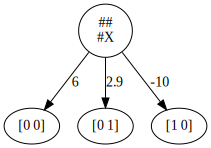

In [12]:
# Action-value test

av = ActionValue()

s = State([[-1,-1],[-1,1]])

a1 = Action([0,0])
a2 = Action([0,1])
a3 = Action([1,0])

av[s,a1]=6
av[s,a2]=2.9
av[s,a3]=-10

av

In [13]:
class Returns:
    def __init__(self):
        self.returns_dict = {}
    
    # Lazy initialization
    def __getitem__(self, key):
        state, action = key
        if self.returns_dict.get(state) is None:
            self.returns_dict[state] = {action : []} # Arbitrarily initialization
        elif self.returns_dict[state].get(action) is None:
            self.returns_dict[state][action] = [] # Arbitrarily initialization
            
        return self.returns_dict[state][action]
    
    def __setitem__(self, key, value):
        state, action = key
        if self.returns_dict.get(state) is None:
            self.returns_dict[state] = {}
        self.returns_dict[state][action] = value
    
    def _repr_svg_(self):
        graph = Digraph()
        graph.attr(rankdir="LR")
        for state, actions in self.returns_dict.items():
            for action, returns in actions.items():
                graph.attr('node', shape='doublecircle')
                state_hash = str(uuid.uuid4())
                graph.node(state_hash, str(state))
                graph.attr('node', shape='circle')
                action_hash = str(uuid.uuid4())
                graph.node(action_hash, str(action))
                graph.edge(state_hash, action_hash)
                
                graph.attr('node', shape='diamond')
                last_hash = action_hash
                for the_return in returns:
                    return_hash = str(uuid.uuid4())
                    graph.node(return_hash, str(the_return))
                    graph.edge(last_hash, return_hash)
                    last_hash = return_hash
                    
        return graph._repr_svg_()

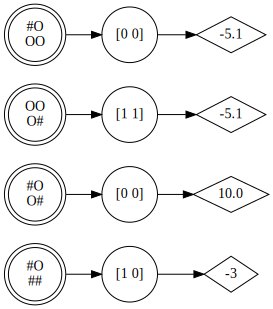

In [14]:
# Returns test

r = Returns()

s1 = State([[-1,0],[-1,-1]])
a1 = Action([1,0])
G = -3
r[s1,a1].append(G)

s2 = State([[-1,0],[0,-1]])
a2 = Action([0,0])
G = 10.0
r[s2,a2].append(G)

s3 = State([[0,0],[0,-1]])
a3 = Action([1,1])
G = -5.1
r[s3,a3].append(G)

s4 = State([[-1,0],[0,0]])
a4 = Action([0,0])
G = -5.1
r[s4,a4].append(G)

r

In [15]:
class Episode(list):
    def __init__(self, the_list=[]):
        super().__init__(the_list)

    def __str__(self):
        representation = ''
        for element in self:
            if type(element) == int:
                representation += 'Reward:\n'
                representation += str(element)
                representation += '\n'
            elif (type(element[0]), type(element[1])) == (State, Action):
                representation += 'State:\n'
                representation += str(element[0])
                representation += '\n\n'
                representation += 'Action:\n'
                representation += str(element[1])
                representation += '\n'      
            else:
                print("Ivalid episode's element error")
                raise
            representation += '\n'
        return representation
    
    def _repr_svg_(self):
        graph = Digraph()
        graph.attr(rankdir="LR")
        last_reward_hash = None
        for i in range(int(len(self)/2)):
            state = self[2*i][0]
            action = self[2*i][1]
            reward = self[2*i+1]
                
            # State node
            graph.attr('node', shape='doublecircle')
            state_hash = str(uuid.uuid4())
            graph.node(state_hash, str(state))
            
            if last_reward_hash:
                graph.edge(last_reward_hash, state_hash)
                
            # Action node
            graph.attr('node', shape='circle')
            action_hash = str(uuid.uuid4())
            graph.node(action_hash, str(action))
            graph.edge(state_hash, action_hash)
            
            # Next state node
            graph.attr('node', shape='diamond')
            reward_hash = str(uuid.uuid4())
            graph.node(reward_hash, str(reward))
            graph.edge(action_hash, reward_hash)
            last_reward_hash = reward_hash
        
        return graph._repr_svg_()

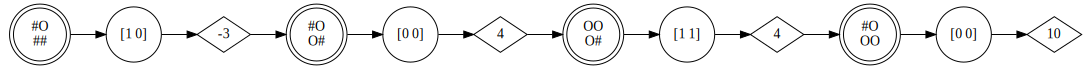

In [16]:
# Episode test

e = Episode()

s1 = State([[-1,0],[-1,-1]])
a1 = Action([1,0])
e.append((s1,a1))
r1 = -3
e.append(r1)

s2 = State([[-1,0],[0,-1]])
a2 = Action([0,0])
e.append((s2,a2))
r2 = 4
e.append(r2)

s3 = State([[0,0],[0,-1]])
a3 = Action([1,1])
e.append((s3,a3))
r3 = -8
e.append(r2)

s4 = State([[-1,0],[0,0]])
a4 = Action([0,0])
e.append((s4,a4))
r4 = 10
e.append(r4)

e

In [56]:
class Model:
    def __init__(self):
        self.model_dict = {}
    
    # Lazy initialization
    def __getitem__(self, key):
        state, action = key
        return self.model_dict.get(state, {}).get(action)
    
    def __setitem__(self, key, value):
        state, action = key
        if self.model_dict.get(state) is None:
            self.model_dict[state] = {}
        self.model_dict[state][action] = value
    
    def _repr_svg_(self):
        graph = Digraph()
        for state, actions in self.model_dict.items():
            for action, next_state in actions.items():
                # State node
                graph.attr('node', shape='doublecircle')
                graph.attr('node', style='', color='', fontcolor = 'black')
                state_hash = str(hash(state))
                graph.node(state_hash, str(state))
                
                # Action node
                graph.attr('node', shape='circle')
                graph.attr('node', style='filled', color='black', fontcolor = 'white')
                action_hash = str(hash(action))+state_hash
                graph.node(action_hash, str(action))
                graph.edge(state_hash, action_hash)
                
                # Next state node
                graph.attr('node', shape='doublecircle')
                graph.attr('node', style='', fontcolor = 'black')
                next_state_hash = str(hash(next_state))
                graph.node(next_state_hash, str(next_state))
                graph.edge(action_hash, next_state_hash)
        return graph._repr_svg_()

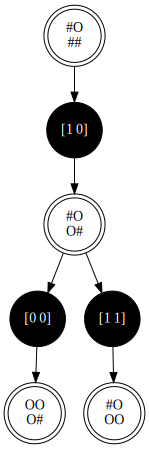

In [58]:
# Model test

m = Model()

s1 = State([[-1,0],[-1,-1]])
a1 = Action([1,0])
s2 = State([[-1,0],[0,-1]])
m[s1,a1] = s2

a2 = Action([0,0])
s3 = State([[0,0],[0,-1]])
m[s2,a2] = s3

a3 = Action([1,1])
s4 = State([[-1,0],[0,0]])
m[s2,a3] = s4

m

In [122]:
class MDP:
    def __init__(self, model, action_value, policy):
        self.model = model
        self.action_value = action_value
        self.policy = policy
        
        mdp_graph = Digraph()
        
        model_dict = self.model.model_dict
        for state, actions in model_dict.items():
            for action, next_state in actions.items():
                # State node
                mdp_graph.attr('node', shape='doublecircle', style='', fontcolor = 'black')
                state_hash = str(hash(state))
                mdp_graph.node(state_hash, str(state))
                
                # Action node
                mdp_graph.attr('node', shape='circle', style='filled', color='black',
                               fontcolor = 'white')
                action_hash = str(hash(action))+state_hash
                mdp_graph.node(action_hash, str(action))
                this_action_value = self.action_value[state, action]
                if self.policy[state] == action:
                    this_action_color = 'red'
                else:
                    this_action_color = 'black'
                mdp_graph.edge(state_hash,
                               action_hash,
                               label=str(this_action_value),
                               color = this_action_color)
                
                # Next state node
                mdp_graph.attr('node', shape='doublecircle', style='', fontcolor = 'black')
                next_state_hash = str(hash(next_state))
                mdp_graph.node(next_state_hash, str(next_state))
                mdp_graph.edge(action_hash, next_state_hash)
        
        self.mdp_graph = mdp_graph
    
    def _repr_svg_(self):
        return self.mdp_graph._repr_svg_()

### RL Agent

In [98]:
class Agent:
    def __init__(self, environment, player):
        self.player = player
        self.env = environment
        
        self.policy = Policy(self.env)
        self.action_value = ActionValue()
        self.returns = Returns()
        self.last_episode = Episode()
        self.model = Model()
        self.last_state = None
        self.last_action = None
        self.last_MDP = None
    
    def step(self, state, epsilon):

        # Choose action in epsilon-greedy way
        if np.random.rand() >= epsilon:
            action = self.policy[state]
        else:
            if self.env.possible_actions:
                action = Action(random.choice(self.env.possible_actions))
                self.policy[state] = action
            else:
                action = Action([])
                
        self.last_episode.append((state, action)) # Register state and action
        raw_state, reward, done, _ = env.step(action.array, self.player) # Take action
        
        # Register model transition
        if self.last_state and self.last_action:
            self.model[self.last_state, self.last_action] = state
        self.last_state, self.last_action = state, action

        self.last_episode.append(reward) # Register reward
        return State(raw_state), done
    
    def random_step(self, state):
        action = Action(random.choice(self.env.possible_actions)) # Choose action
        self.last_episode.append((state, action)) # Register state and action
        raw_state, reward, done, _ = env.step(action.array, self.player) # Take action
        
        # Register model transition
        if self.last_state and self.last_action:
            self.model[self.last_state, self.last_action] = state
        self.last_state, self.last_action = state, action
        
        self.last_episode.append(reward) # Register reward
        return State(raw_state), done
    
    def get_MDP(self):
        self.last_MDP = MDP(self.model, self.action_value, self.policy)
        return self.last_MDP
    
    def reset_policy(self):
        self.policy = Policy(self.env)
    
    def reset_action_value(self):
        self.action_value = ActionValue()
    
    def reset_returns(self):
        self.returns = Returns()

    def reset_episode(self):
        self.last_episode = Episode()
        self.last_state = None
        self.last_action = None
    
    def reset_model(self):
        self.model = Model()
        self.last_state = None
        self.last_action = None
    
    def reset_agent():
        self.reset_policy()
        self.reset_action_value()
        self.reset_returns()
        self.reset_episode()
        self.reset_model()
        

### Monte Carlo with Exploring Starts algorithm implementation

In [99]:
class MonteCarloES:
    def __init__(self, agent1, agent2):
        self.agent1 = agent1
        self.agent2 = agent2
        self.agent1_G = []
        self.agent2_G = []
        self.epsilons = []
        
    def train(self, episodes_no=1, initial_epsilon=0.3):
        for i in range(episodes_no):
            epsilon = np.e**(-i/episodes_no*5) * initial_epsilon # Epsilon decaying
            self.epsilons.append(epsilon) # Register epsilon for plotting purpose
            
            self.gen_episode(self.agent1, self.agent2, epsilon)
            self.agent1_G.append(self.pass_episode(self.agent1))
            self.agent2_G.append(self.pass_episode(self.agent2))
    
    def gen_episode(self, agent1, agent2, epsilon):
        # Reset agents' episodes
        agents = [agent1, agent2]
        for a in agents:
            a.reset_episode()

        # Players queue
        agents = cycle(agents)
        current_agent = next(agents)

        # Initialize environment
        env = agent1.env
        players = [Player('A', 0), Player('B', 1)]
        size = 3
        marks_required = 3
        env.initialize(players, size, marks_required)

        # Generate episode
        done = False
        initial_state = State(env.random_initial_state()) # Random state due to Exploring Starts approach
        state, done = current_agent.random_step(initial_state) # Random action due to Exploring Starts approach
        while not done:
            current_agent = next(agents)
            state, done = current_agent.step(state, epsilon)

#         current_agent = next(agents)
    
    def pass_episode(self, agent):
        episode = agent.last_episode
        gamma = 0.9                         # Discount factor
        G = 0                               # Episode's accumulative discounted total reward/return
        steps_no = len(episode)//2
        for t in reversed(range(steps_no)):
            S, A = episode[2*t]             # This step's (state, action) pair
            R = episode[2*t+1]              # This step's reward

            G = gamma * G + R               # Calculate discounted return
            
            # Update rule according to the Monte Carlo first-step approach
            if not (S,A) in episode[0:2*t]:
                # Policy evaluation
                agent.returns[S,A].append(G)
                agent.action_value[S,A] = np.mean(agent.returns[S,A])
                # Greedy policy improvement
                agent.policy[S] = agent.action_value.argmax_a(S)
        return G

### Training

In [140]:
# Initialization

env = gym.make('tic_tac_toe:tictactoe-v0')
agent1 = Agent(env, players[0])
agent2 = Agent(env, players[1])
mces = MonteCarloES(agent1, agent2)

Returns vs episodes:


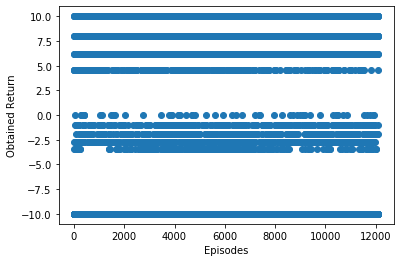

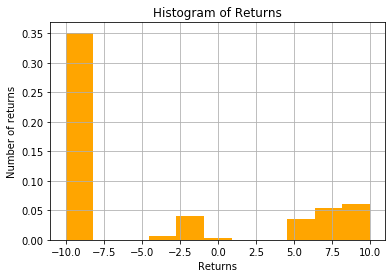

Epsilones vs episodes


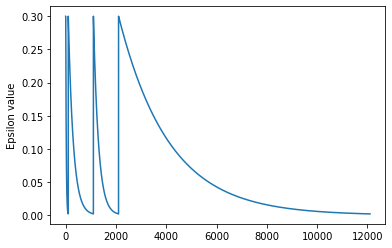

In [154]:
# Train
mces.train(10000, initial_epsilon=0.3)

# Plot 
x = list(range(len(mces.agent2_G)))
y = mces.agent2_G
plt.scatter(x, y)
plt.ylabel('Obtained Return')
plt.xlabel('Episodes')
print("Returns vs episodes:")
plt.show()

x = np.array(mces.agent2_G)[-1000:-1]
n, bins, patches = plt.hist(x, bins='auto', density=True, facecolor='orange', alpha=1)
plt.xlabel('Returns')
plt.ylabel('Number of returns')
plt.title('Histogram of Returns')
plt.grid(True)
plt.show()

plt.plot(mces.epsilons)
plt.ylabel('Epsilon value')
plt.ylabel('Epsilon value')
print("Epsilones vs episodes")
plt.show()

In [151]:
mdp = agent1.get_MDP()
mdp.mdp_graph.view()
# mdp

'Digraph.gv.pdf'

Last episode


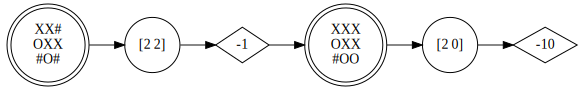

In [152]:
print("Last episode")
agent1.last_episode

Action-value function


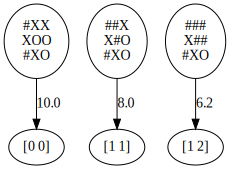

In [127]:
print("Action-value function")
agent1.action_value

Policy


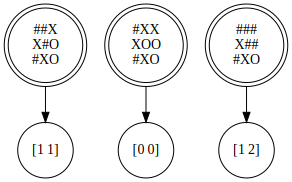

In [128]:
print("Policy")
agent1.policy

Returns for (State, Action) pairs


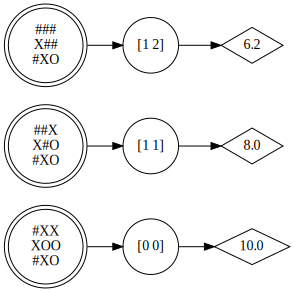

In [129]:
print("Returns for (State, Action) pairs")
agent1.returns

In [22]:
# lens = []
# for state, actions in agent1.returns.returns_dict.items():
#     for action, returns in actions.items():
#         lens.append(len(returns))
#         if len(returns) >= 10:
#             print("State:")
#             print(state)
#             print(f"Action: {action}")
#             print(f"Returns: {returns}")

Model


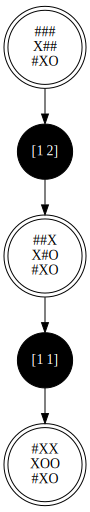

In [130]:
print("Model")
agent1.model

In [24]:
# import gym
# import sys
# sys.path.append('/home/jan/WinTacToe/src/extensions/games/tic_tac_toe')
# from tic_tac_toe_logic import *
# players = [Player('A', 0), Player('B', 1)]
# size = 3
# marks_required = 3
# env = gym.make('tic_tac_toe:tictactoe-v0')
# env.initialize(players, size, marks_required)
# s = env.random_initial_state()
# State(s)

# TODO
- [ ] Zagrać przeciwko randomowemu graczowi
- [ ] Zaimplementować Human Player Agent
- [X] zmienić episode na last_episode w klasie Agent
- [ ] Rozegrać gry ze standardowym stanem początkowym
- [X] Dodać MDP